# Model training

#### 1. Prepare dataset:

In [72]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
import joblib
import torch
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [130]:
# Declare general variables
NAME_COMPANY = "ISA_Historical_Info.csv"
PATH_RAW = f"../data/raw/{NAME_COMPANY}"
PATH_FINAL_TRAIN = f"../data/processed/processed_training_set_{NAME_COMPANY}"
MIN_MAX_SCALER_TRANSFORMER_PATH =  "../config/model/transformers_min_max_scaler.pkl"
PATH_FINAL_TEST = f"../data/processed/processed_testing_set_{NAME_COMPANY}"
PATH_FINAL_X_TRAIN = f"../data/final/final_X_training_set_{NAME_COMPANY}"
PATH_FINAL_Y_TRAIN = f"../data/final/final_Y_training_set_{NAME_COMPANY}"
PATH_FINAL_X_TEST = f"../data/final/final_X_training_set_{NAME_COMPANY}"
PATH_FINAL_Y_TEST = f"../data/final/final_Y_training_set_{NAME_COMPANY}"
MODEL_PATH = f"../models/model_lstm_{NAME_COMPANY}"


In [74]:
# Import the data transform to start the training process
dataset_train_processed = pd.read_csv(PATH_FINAL_TRAIN)

In [75]:
dataset_train_processed.head()

,Close
0,0.758420
1,0.761947
2,0.758420
3,0.755246
4,0.751014


In [76]:
dataset_train_processed.shape

(4714, 1)

#### Prepare info to train LSTM network

In [79]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(dataset_train_processed)

for i in range(time_step, m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    #X_train.append(dataset_processed[i-time_step:i,0])
    X_train.append(dataset_train_processed.iloc[i-time_step:i, 0].values)

    # Y: el siguiente dato
    Y_train.append(dataset_train_processed.iloc[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)


In [82]:
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4654, 60, 1)

In [84]:
Y_train.shape

(4654,)

#### Build the LSTM

In [85]:
# Valores iniciales
dim_entrada = (X_train.shape[1],1) # 60 datos de una feature
dim_salida = 1
na = 50

# Crear el modelo
model_lstm = Sequential()

# Añadir la capa LSTM
model_lstm.add(LSTM(units=na, return_sequences=True, input_shape= dim_entrada))
model_lstm.add(LSTM(units=na))

# Añadir una capa densa para la salida
model_lstm.add(Dense(dim_salida))

# Compilar el modelo
model_lstm.compile(optimizer='rmsprop', loss='mean_squared_error')

# Resumen del modelo
model_lstm.summary()


/opt/anaconda3/envs/mlops_market_models/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the model:

In [86]:
# Train the model
model_lstm.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0179 - val_loss: 2.4076e-04
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0014 - val_loss: 2.6011e-04
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.7207e-04 - val_loss: 1.6529e-04
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 7.4652e-04 - val_loss: 4.0361e-05
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 7.0755e-04 - val_loss: 3.1673e-05
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 7.4219e-04 - val_loss: 1.1554e-04
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.9765e-04 - val_loss: 1.6131e-04
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.4029e-04 - val_loss: 7.2521e-05
Epoch 9/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.9754e-04 - val_loss: 1.9338e-04
Epoch 10/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 6.2670e-04 - val_loss: 6.8911e-05
Epoch 11/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - l

#### Evaluate the model
#### Prepare test info to train LSTM network

In [87]:
testing_set = pd.read_csv(PATH_FINAL_TEST)
testing_set.head(3)

,Close
0,16960.0
1,17020.0
2,16840.0


In [88]:
testing_set.shape

(657, 1)

In [89]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))

# Ajustar el escalador a la columna 'Close' en los datos de entrenamiento
testing_set['Close'] = min_max_scaler.fit_transform(testing_set[['Close']])

# Transformar la columna 'Close' en los datos de prueba
# test_data['Close'] = scaler.transform(test_data[['Close']])

print("Datos de entrenamiento con 'Close' escalado:")
print(testing_set['Close'].head())

Datos de entrenamiento con 'Close' escalado:
0    0.279646
1    0.284956
2    0.269027
3    0.297345
4    0.325664
Name: Close, dtype: float64


In [96]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_test = []
m = len(testing_set)

for i in range(time_step, m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    #X_train.append(dataset_processed[i-time_step:i,0])
    X_test.append(testing_set.iloc[i-time_step:i, 0].values)


60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319


In [97]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(597, 60, 1)

In [98]:
prediccion = model_lstm.predict(X_test)
prediccion = min_max_scaler.inverse_transform(prediccion)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [101]:
prediccion.shape

(597, 1)

In [109]:
prediccion

array([[17866.174 ],
       [17895.36  ],
       [17871.648 ],
       [17814.232 ],
       [17771.086 ],
       [17780.123 ],
       [17840.578 ],
       [17982.41  ],
       [18197.117 ],
       [18439.518 ],
       [18638.68  ],
       [18809.227 ],
       [18904.123 ],
       [18867.385 ],
       [18781.967 ],
       [18782.088 ],
       [18758.809 ],
       [18684.29  ],
       [18616.85  ],
       [18582.271 ],
       [18589.379 ],
       [18616.393 ],
       [18649.969 ],
       [18682.643 ],
       [18716.035 ],
       [18729.836 ],
       [18739.953 ],
       [18749.54  ],
       [18757.58  ],
       [18795.264 ],
       [18856.055 ],
       [18881.25  ],
       [18793.586 ],
       [18749.61  ],
       [18638.576 ],
       [18486.898 ],
       [18373.387 ],
       [18254.047 ],
       [18173.25  ],
       [18109.11  ],
       [18059.117 ],
       [18078.096 ],
       [18142.723 ],
       [18235.52  ],
       [18383.588 ],
       [18632.816 ],
       [18914.127 ],
       [19159

In [102]:
X_test.shape

(597, 60, 1)

In [110]:
X_test

array([[[0.27964602],
        [0.28495575],
        [0.26902655],
        ...,
        [0.34867257],
        [0.35752212],
        [0.34690265]],

       [[0.28495575],
        [0.26902655],
        [0.29734513],
        ...,
        [0.35752212],
        [0.34690265],
        [0.39646018]],

       [[0.26902655],
        [0.29734513],
        [0.32566372],
        ...,
        [0.34690265],
        [0.39646018],
        [0.33628319]],

       ...,

       [[0.98230088],
        [0.92920354],
        [0.91681416],
        ...,
        [0.76106195],
        [0.69911504],
        [0.78053097]],

       [[0.92920354],
        [0.91681416],
        [0.95929204],
        ...,
        [0.69911504],
        [0.78053097],
        [0.7920354 ]],

       [[0.91681416],
        [0.95929204],
        [0.93274336],
        ...,
        [0.78053097],
        [0.7920354 ],
        [0.77876106]]])

In [104]:
# Funciones auxiliares
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()


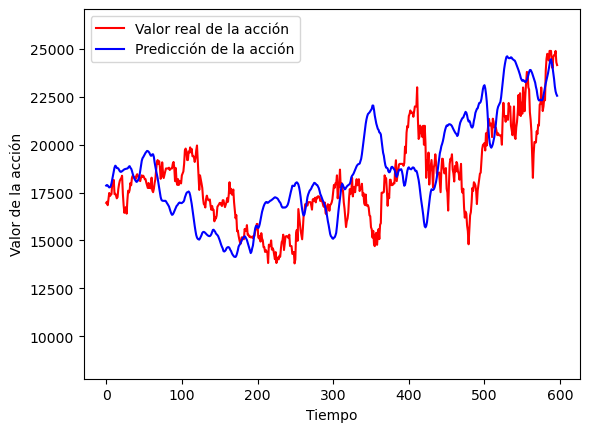

In [113]:
testing_set = pd.read_csv(PATH_FINAL_TEST)

graficar_predicciones(testing_set.values, prediccion)

In [114]:
# Evaluar el modelo en los datos de prueba (si tienes)
#model_lstm.evaluate(testing_set, prediccion)

X_test.shape

(597, 60, 1)

In [115]:
testing_set.shape

(657, 1)

In [125]:
prediccion_df = pd.DataFrame(prediccion, columns=['Close price prediction'])

# Mostrar el DataFrame
print(prediccion_df)


     Close price prediction
0              17866.173828
1              17895.359375
2              17871.648438
3              17814.232422
4              17771.085938
..                      ...
592            23429.289062
593            23041.759766
594            22785.441406
595            22644.042969
596            22559.080078

[597 rows x 1 columns]


In [128]:
# Comparar predicciones con valores reales
for i in range(10):  # Solo para mostrar algunas comparaciones
    print(f"Predicción: {prediccion_df['Close price prediction'][i]}, Real: {testing_set['Close'][i]}")


Predicción: 17866.173828125, Real: 16960.0
Predicción: 17895.359375, Real: 17020.0
Predicción: 17871.6484375, Real: 16840.0
Predicción: 17814.232421875, Real: 17160.0
Predicción: 17771.0859375, Real: 17480.0
Predicción: 17780.123046875, Real: 17320.0
Predicción: 17840.578125, Real: 17380.0
Predicción: 17982.41015625, Real: 17420.0
Predicción: 18197.1171875, Real: 18000.0
Predicción: 18439.517578125, Real: 17940.0


In [131]:
# Guarda el modelo en formato HDF5
model_lstm.save('modelo_lstm.h5')
# keras.saving.save_model(model_lstm, 'my_model.keras')
